In [ ]:
%load_ext autoreload
%autoreload 2

from datasets import load_dataset
from boolrank import *

# dk what this loads
# dataset = load_dataset("data", split="train")
file = "training-logs"
dataset = load_dataset("json", data_files=f"data/{file}.jsonl", split="train")
bool_key = "q"
text_key = "d"

data = dataset.train_test_split(test_size=0.1, seed=42)
print(data)

model = DualSiglip2Model('BAAI/llm-embedder')

c:\Users\Simon\miniconda3\envs\RP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['q', 'quality', 'd'],
        num_rows: 3079
    })
    test: Dataset({
        features: ['q', 'quality', 'd'],
        num_rows: 343
    })
})


In [2]:
from transformers import Trainer, TrainingArguments
import os
from transformers.utils.notebook import NotebookProgressCallback
from callbacks import NotebookProgressCallbackNoTable
from compute_metrics import compute_metrics

os.environ["WANDB_PROJECT"] = "Boolean-Ranking"
os.environ["WANDB_LOG_MODEL"] = "false"

epochs = 10
batch_size = 2
lr = 1e-5
decay = 0.01
model_name = model.model_name.split("/")[-1]
model_path = f"{model_name}/b{batch_size}_lr{lr:.0e}_decay{decay:.0e}"

training_args = TrainingArguments(
    output_dir="models/" + model_path,
    per_device_train_batch_size=batch_size,
    num_train_epochs=epochs,
    learning_rate=lr,
    weight_decay=decay,
    save_steps=1000,
    save_total_limit=1,
    remove_unused_columns=False,
    bf16=True,
    optim="adamw_bnb_8bit",
    logging_steps=100,
    report_to="wandb",
    eval_steps=200,
    eval_strategy="steps",
    eval_delay=200,
    per_device_eval_batch_size=1000,
    # max_steps=1000,
    # torch_compile=True,
    # torch_compile_backend="inductor"
)

def collate_fn(batch):
    d = {
        "in_bool": [ex["q"] for ex in batch],
        "in_text": [ex["d"] for ex in batch],
    }
    return d

trainer = Trainer(
    model,
    training_args,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)

trainer.remove_callback(NotebookProgressCallback)
trainer.add_callback(NotebookProgressCallbackNoTable)

trainer.train()
# try: trainer.train(resume_from_checkpoint=True)
# except: trainer.train(resume_from_checkpoint=False)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: simon-doehl (simon-doehl-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=15400, training_loss=1.0766566135356952, metrics={'train_runtime': 1285.7885, 'train_samples_per_second': 23.946, 'train_steps_per_second': 11.977, 'total_flos': 0.0, 'train_loss': 1.0766566135356952, 'epoch': 10.0})

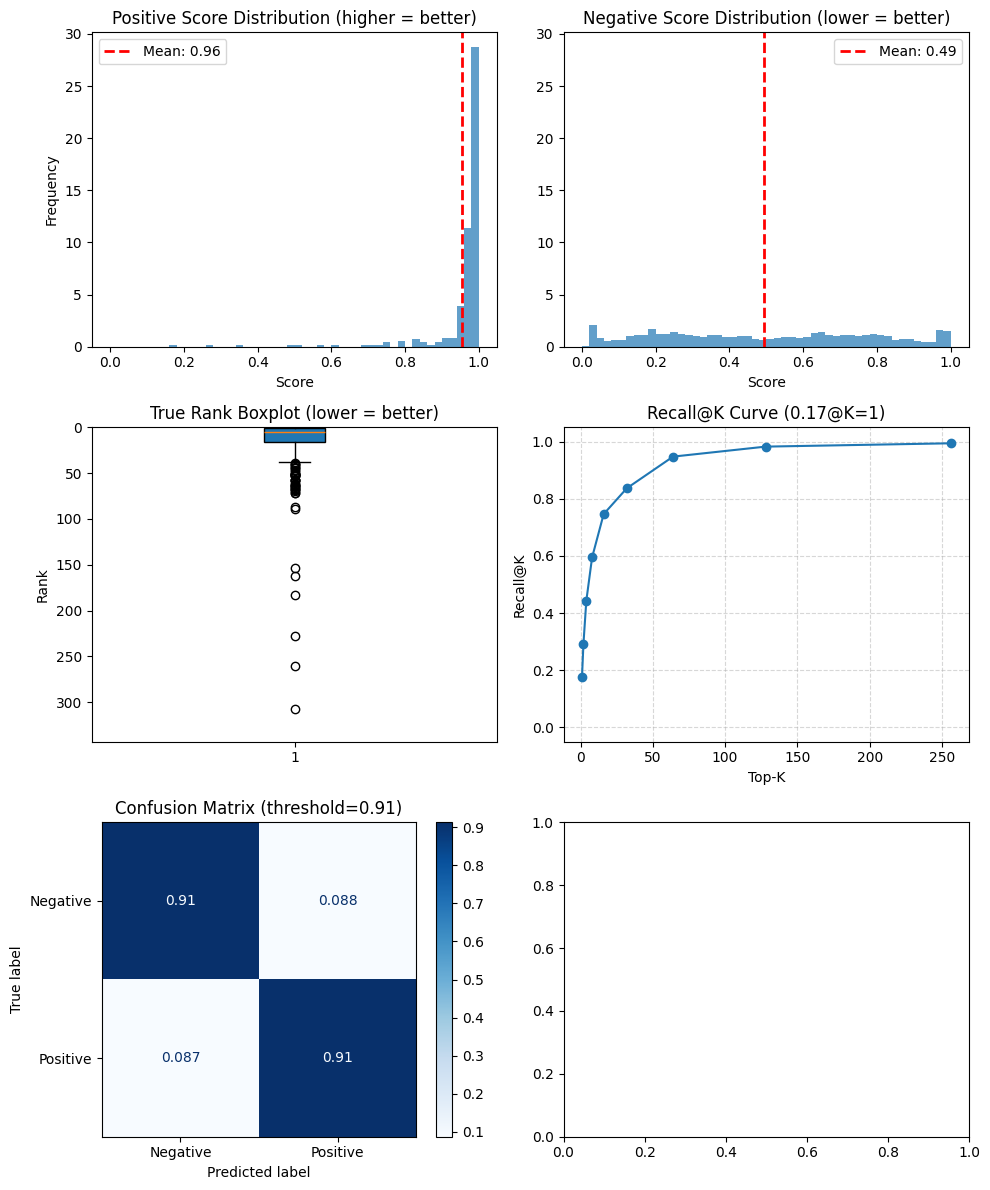

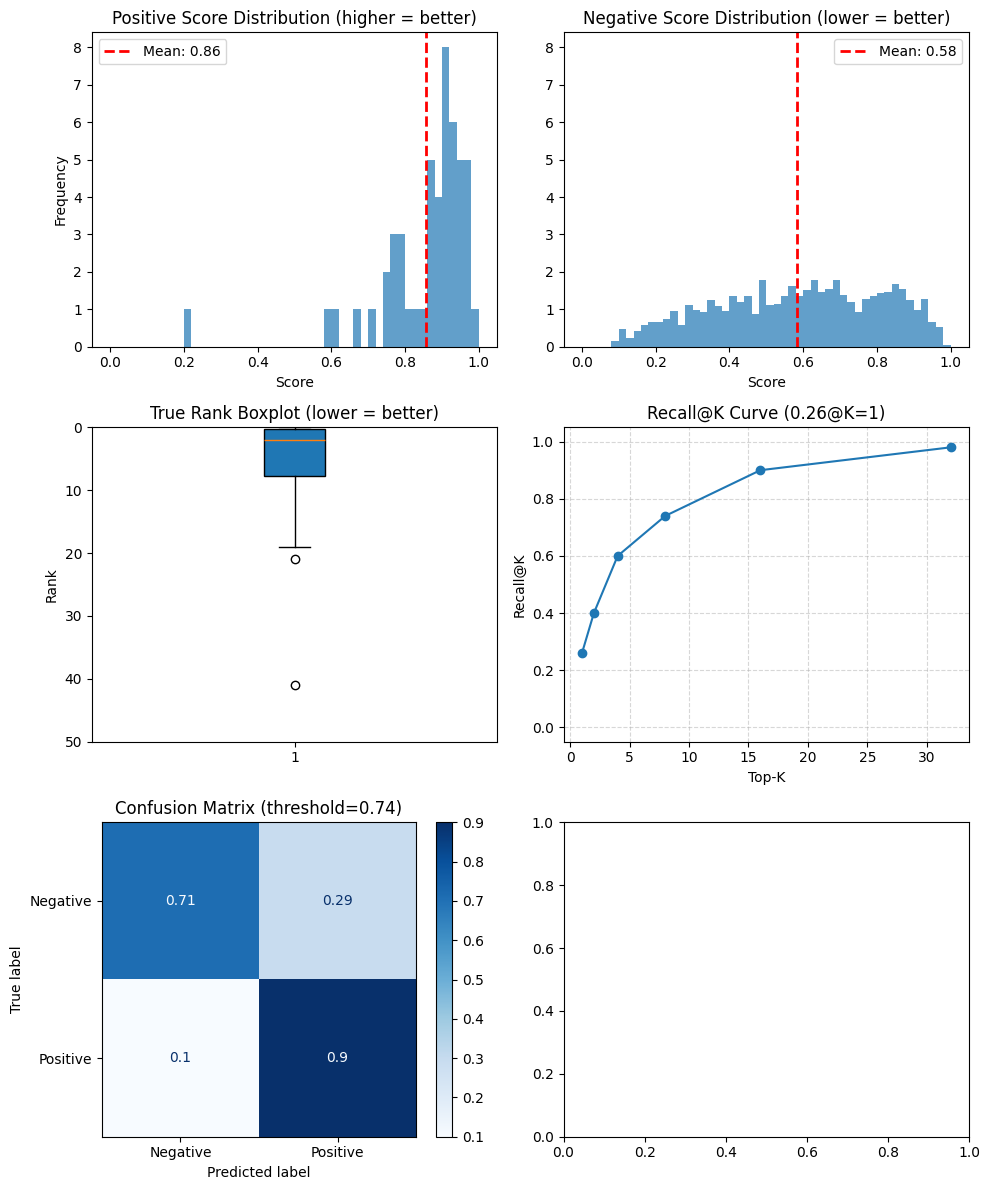

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------




In [3]:
from evaluation import ModelEvaluator
# paths = [r"models/siglip2/old/b2-bf-8b/e4", r"models/siglip2/old/b3-bf-8b"]
paths = [None]
amt = 2000
format = "pdf"
bench_data = load_dataset("json", data_files="data/bench_data.jsonl", split="train")
for path in paths:
    if path is not None:
        model.load(path + "/model.safetensors")
        print(path)
    else: path = model_path
    eval = ModelEvaluator(model)
    res = eval.evaluate(data["test"][bool_key][:amt], data["test"][text_key][:amt], plot=True)
    res["plot"].savefig(f"models/{path}/test_stats.{format}", format=format)
    res = eval.evaluate(bench_data["query"][:amt], bench_data["title"][:amt], plot=True)
    res["plot"].savefig(f"models/{path}/TAR_stats.{format}", format=format)
    print(("-" * 100 + "\n\n") * 2)